### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

C:\Users\shasw\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
Time_matrix[0][3][1]

array([10.,  6.,  8.,  5.,  7.,  4.,  6.])

#### Tracking the state-action pairs for checking convergence


In [4]:
def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [5]:
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [6]:
def initialise_tracking_states(): 
    samvalues = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2))] 
    #select any 4 Q-values 
    for q_value in samvalues: 
        state = Q_state(q_value[0]) 
        action = q_value[1] 
        states_track[state][action] = []

In [7]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01       
        self.epsilon_max = 1
        self.epsilon_decay =0.99 
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state):
    # Write your code here:        
        poss_index, actions = env.requests(state)        
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon_max:
            # explore: choose a random action from all possible actions            
            action = random.choice(actions)
            return action
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state_encode = env.state_encod_arch1(state)
            state_batch = state_encode.reshape(1, self.state_size)
            q_value = self.model.predict(state_batch)
            qvalue = [q_value[0][index] for index in poss_index]
            #print("poss_index", poss_index, " actions ", actions, " state ",state)
            if not poss_index:
                return actions[0]
            else:
                index = np.argmax(qvalue)            
                return actions[index]     
     
        
    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, terminals = [], [],[]
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                terminals.append(terminal)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
             
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):                
                if terminals[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 

    def save(self, name):
        self.model.save(name)    
        
   
      

In [10]:
Episodes = 2000

### DQN block

In [11]:
#  environment
env = CabDriver()

# get size of state and action from environment
state_size = len(env.state_space[0])  # equal to 4 in case of cartpole 
action_size = len(env.action_space)            # equal to 2 in case of cartpole

In [21]:


# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(action_size=action_size, state_size=state_size)


# to store rewards in each episode
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here   
    # Call the environment   
    # Call all the initialised variables of the environment
    score = 0 
    action_space, state_space, state = env.reset()
    terminal_state = False
    #Call the DQN agent
        
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        # populate update_input and update_output and the lists rewards, actions, done
       
        # get action for the current state and take a step in the environment
        action = agent.get_action(state)       
        reward = env.reward_func(state, action, Time_matrix) 
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)
        
        # save the sample <s, a, r, s', done> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)

        # train after each step
        agent.train_model()

        # add reward to the total score of this episode
        score += reward
        state = next_state


    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon_max > agent.epsilon_min:
        agent.epsilon_max *= agent.epsilon_decay

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon_max))
    # every few episodes:
    #if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()
        # save model weights
        # agent.save_model_weights(name="model_weights.h5")
    # every few episodes:
    if episode % 100 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()
        # save model weights
        save_tracking_states() 
        save_obj(States_track,'States_tracked') 
        agent.save(name="CarPol_model.h5")

        

episode 0, reward -464.0, memory_length 134, epsilon 0.99
episode 1, reward -609.0, memory_length 289, epsilon 0.9801
episode 2, reward -757.0, memory_length 430, epsilon 0.9702989999999999
episode 3, reward -1040.0, memory_length 571, epsilon 0.96059601
episode 4, reward -513.0, memory_length 722, epsilon 0.9509900498999999
episode 5, reward -378.0, memory_length 868, epsilon 0.9414801494009999
episode 6, reward -468.0, memory_length 1014, epsilon 0.9320653479069899
episode 7, reward -297.0, memory_length 1160, epsilon 0.92274469442792
episode 8, reward -315.0, memory_length 1298, epsilon 0.9135172474836407
episode 9, reward -169.0, memory_length 1449, epsilon 0.9043820750088043
episode 10, reward -432.0, memory_length 1578, epsilon 0.8953382542587163
episode 11, reward -405.0, memory_length 1730, epsilon 0.8863848717161291
episode 12, reward -645.0, memory_length 1862, epsilon 0.8775210229989678
episode 13, reward -286.0, memory_length 1998, epsilon 0.8687458127689781
episode 14, rew

episode 112, reward -208.0, memory_length 2000, epsilon 0.3212010745647914
episode 113, reward -311.0, memory_length 2000, epsilon 0.3179890638191435
episode 114, reward -37.0, memory_length 2000, epsilon 0.31480917318095203
episode 115, reward -316.0, memory_length 2000, epsilon 0.3116610814491425
episode 116, reward 54.0, memory_length 2000, epsilon 0.30854447063465107
episode 117, reward -162.0, memory_length 2000, epsilon 0.30545902592830454
episode 118, reward -554.0, memory_length 2000, epsilon 0.3024044356690215
episode 119, reward 42.0, memory_length 2000, epsilon 0.29938039131233124
episode 120, reward -486.0, memory_length 2000, epsilon 0.2963865873992079
episode 121, reward -317.0, memory_length 2000, epsilon 0.29342272152521587
episode 122, reward -468.0, memory_length 2000, epsilon 0.2904884943099637
episode 123, reward -346.0, memory_length 2000, epsilon 0.28758360936686406
episode 124, reward -293.0, memory_length 2000, epsilon 0.2847077732731954
episode 125, reward -37.

episode 221, reward -217.0, memory_length 2000, epsilon 0.1074022057426376
episode 222, reward -149.0, memory_length 2000, epsilon 0.10632818368521123
episode 223, reward 76.0, memory_length 2000, epsilon 0.10526490184835911
episode 224, reward -50.0, memory_length 2000, epsilon 0.10421225282987552
episode 225, reward -108.0, memory_length 2000, epsilon 0.10317013030157676
episode 226, reward -42.0, memory_length 2000, epsilon 0.10213842899856099
episode 227, reward -158.0, memory_length 2000, epsilon 0.10111704470857538
episode 228, reward -108.0, memory_length 2000, epsilon 0.10010587426148963
episode 229, reward -266.0, memory_length 2000, epsilon 0.09910481551887473
episode 230, reward -212.0, memory_length 2000, epsilon 0.09811376736368599
episode 231, reward 108.0, memory_length 2000, epsilon 0.09713262969004913
episode 232, reward -162.0, memory_length 2000, epsilon 0.09616130339314863
episode 233, reward -18.0, memory_length 2000, epsilon 0.09519969035921715
episode 234, reward

episode 330, reward -613.0, memory_length 2000, epsilon 0.03591281197926689
episode 331, reward -374.0, memory_length 2000, epsilon 0.035553683859474224
episode 332, reward -243.0, memory_length 2000, epsilon 0.03519814702087948
episode 333, reward -194.0, memory_length 2000, epsilon 0.03484616555067068
episode 334, reward -271.0, memory_length 2000, epsilon 0.034497703895163975
episode 335, reward -77.0, memory_length 2000, epsilon 0.03415272685621234
episode 336, reward -209.0, memory_length 2000, epsilon 0.03381119958765021
episode 337, reward -145.0, memory_length 2000, epsilon 0.03347308759177371
episode 338, reward -118.0, memory_length 2000, epsilon 0.03313835671585597
episode 339, reward -46.0, memory_length 2000, epsilon 0.03280697314869741
episode 340, reward -104.0, memory_length 2000, epsilon 0.032478903417210436
episode 341, reward -149.0, memory_length 2000, epsilon 0.032154114383038335
episode 342, reward -186.0, memory_length 2000, epsilon 0.03183257323920795
episode 34

episode 438, reward 314.0, memory_length 2000, epsilon 0.012129710294652202
episode 439, reward -279.0, memory_length 2000, epsilon 0.01200841319170568
episode 440, reward 53.0, memory_length 2000, epsilon 0.011888329059788623
episode 441, reward -14.0, memory_length 2000, epsilon 0.011769445769190737
episode 442, reward -100.0, memory_length 2000, epsilon 0.01165175131149883
episode 443, reward 234.0, memory_length 2000, epsilon 0.011535233798383842
episode 444, reward -59.0, memory_length 2000, epsilon 0.011419881460400004
episode 445, reward -63.0, memory_length 2000, epsilon 0.011305682645796004
episode 446, reward -50.0, memory_length 2000, epsilon 0.011192625819338045
episode 447, reward -99.0, memory_length 2000, epsilon 0.011080699561144665
episode 448, reward -175.0, memory_length 2000, epsilon 0.010969892565533218
episode 449, reward 101.0, memory_length 2000, epsilon 0.010860193639877886
episode 450, reward -243.0, memory_length 2000, epsilon 0.010751591703479106
episode 451

episode 546, reward -45.0, memory_length 2000, epsilon 0.009920974201040588
episode 547, reward -96.0, memory_length 2000, epsilon 0.009920974201040588
episode 548, reward 8.0, memory_length 2000, epsilon 0.009920974201040588
episode 549, reward -81.0, memory_length 2000, epsilon 0.009920974201040588
episode 550, reward -28.0, memory_length 2000, epsilon 0.009920974201040588
episode 551, reward 166.0, memory_length 2000, epsilon 0.009920974201040588
episode 552, reward -27.0, memory_length 2000, epsilon 0.009920974201040588
episode 553, reward -301.0, memory_length 2000, epsilon 0.009920974201040588
episode 554, reward -199.0, memory_length 2000, epsilon 0.009920974201040588
episode 555, reward -194.0, memory_length 2000, epsilon 0.009920974201040588
episode 556, reward 36.0, memory_length 2000, epsilon 0.009920974201040588
episode 557, reward -235.0, memory_length 2000, epsilon 0.009920974201040588
episode 558, reward 166.0, memory_length 2000, epsilon 0.009920974201040588
episode 559

episode 654, reward -78.0, memory_length 2000, epsilon 0.009920974201040588
episode 655, reward -140.0, memory_length 2000, epsilon 0.009920974201040588
episode 656, reward -2.0, memory_length 2000, epsilon 0.009920974201040588
episode 657, reward -182.0, memory_length 2000, epsilon 0.009920974201040588
episode 658, reward -15.0, memory_length 2000, epsilon 0.009920974201040588
episode 659, reward 31.0, memory_length 2000, epsilon 0.009920974201040588
episode 660, reward -50.0, memory_length 2000, epsilon 0.009920974201040588
episode 661, reward -73.0, memory_length 2000, epsilon 0.009920974201040588
episode 662, reward -167.0, memory_length 2000, epsilon 0.009920974201040588
episode 663, reward -173.0, memory_length 2000, epsilon 0.009920974201040588
episode 664, reward -87.0, memory_length 2000, epsilon 0.009920974201040588
episode 665, reward -78.0, memory_length 2000, epsilon 0.009920974201040588
episode 666, reward -207.0, memory_length 2000, epsilon 0.009920974201040588
episode 6

episode 762, reward -127.0, memory_length 2000, epsilon 0.009920974201040588
episode 763, reward 7.0, memory_length 2000, epsilon 0.009920974201040588
episode 764, reward -133.0, memory_length 2000, epsilon 0.009920974201040588
episode 765, reward -52.0, memory_length 2000, epsilon 0.009920974201040588
episode 766, reward -153.0, memory_length 2000, epsilon 0.009920974201040588
episode 767, reward 63.0, memory_length 2000, epsilon 0.009920974201040588
episode 768, reward 100.0, memory_length 2000, epsilon 0.009920974201040588
episode 769, reward -185.0, memory_length 2000, epsilon 0.009920974201040588
episode 770, reward 57.0, memory_length 2000, epsilon 0.009920974201040588
episode 771, reward -135.0, memory_length 2000, epsilon 0.009920974201040588
episode 772, reward -25.0, memory_length 2000, epsilon 0.009920974201040588
episode 773, reward -252.0, memory_length 2000, epsilon 0.009920974201040588
episode 774, reward -118.0, memory_length 2000, epsilon 0.009920974201040588
episode 7

episode 870, reward -450.0, memory_length 2000, epsilon 0.009920974201040588
episode 871, reward -109.0, memory_length 2000, epsilon 0.009920974201040588
episode 872, reward 4.0, memory_length 2000, epsilon 0.009920974201040588
episode 873, reward -114.0, memory_length 2000, epsilon 0.009920974201040588
episode 874, reward -123.0, memory_length 2000, epsilon 0.009920974201040588
episode 875, reward -195.0, memory_length 2000, epsilon 0.009920974201040588
episode 876, reward 242.0, memory_length 2000, epsilon 0.009920974201040588
episode 877, reward -259.0, memory_length 2000, epsilon 0.009920974201040588
episode 878, reward -41.0, memory_length 2000, epsilon 0.009920974201040588
episode 879, reward 6.0, memory_length 2000, epsilon 0.009920974201040588
episode 880, reward 65.0, memory_length 2000, epsilon 0.009920974201040588
episode 881, reward -25.0, memory_length 2000, epsilon 0.009920974201040588
episode 882, reward -320.0, memory_length 2000, epsilon 0.009920974201040588
episode 88

episode 978, reward -10.0, memory_length 2000, epsilon 0.009920974201040588
episode 979, reward -122.0, memory_length 2000, epsilon 0.009920974201040588
episode 980, reward 108.0, memory_length 2000, epsilon 0.009920974201040588
episode 981, reward 157.0, memory_length 2000, epsilon 0.009920974201040588
episode 982, reward -113.0, memory_length 2000, epsilon 0.009920974201040588
episode 983, reward 274.0, memory_length 2000, epsilon 0.009920974201040588
episode 984, reward 80.0, memory_length 2000, epsilon 0.009920974201040588
episode 985, reward -27.0, memory_length 2000, epsilon 0.009920974201040588
episode 986, reward 44.0, memory_length 2000, epsilon 0.009920974201040588
episode 987, reward -54.0, memory_length 2000, epsilon 0.009920974201040588
episode 988, reward 99.0, memory_length 2000, epsilon 0.009920974201040588
episode 989, reward -360.0, memory_length 2000, epsilon 0.009920974201040588
episode 990, reward -39.0, memory_length 2000, epsilon 0.009920974201040588
episode 991,

episode 1085, reward -52.0, memory_length 2000, epsilon 0.009920974201040588
episode 1086, reward -306.0, memory_length 2000, epsilon 0.009920974201040588
episode 1087, reward -91.0, memory_length 2000, epsilon 0.009920974201040588
episode 1088, reward -64.0, memory_length 2000, epsilon 0.009920974201040588
episode 1089, reward 107.0, memory_length 2000, epsilon 0.009920974201040588
episode 1090, reward 301.0, memory_length 2000, epsilon 0.009920974201040588
episode 1091, reward -189.0, memory_length 2000, epsilon 0.009920974201040588
episode 1092, reward 84.0, memory_length 2000, epsilon 0.009920974201040588
episode 1093, reward -149.0, memory_length 2000, epsilon 0.009920974201040588
episode 1094, reward 76.0, memory_length 2000, epsilon 0.009920974201040588
episode 1095, reward 45.0, memory_length 2000, epsilon 0.009920974201040588
episode 1096, reward -50.0, memory_length 2000, epsilon 0.009920974201040588
episode 1097, reward -225.0, memory_length 2000, epsilon 0.00992097420104058

episode 1192, reward 96.0, memory_length 2000, epsilon 0.009920974201040588
episode 1193, reward -64.0, memory_length 2000, epsilon 0.009920974201040588
episode 1194, reward 85.0, memory_length 2000, epsilon 0.009920974201040588
episode 1195, reward -70.0, memory_length 2000, epsilon 0.009920974201040588
episode 1196, reward 111.0, memory_length 2000, epsilon 0.009920974201040588
episode 1197, reward -180.0, memory_length 2000, epsilon 0.009920974201040588
episode 1198, reward -105.0, memory_length 2000, epsilon 0.009920974201040588
episode 1199, reward -146.0, memory_length 2000, epsilon 0.009920974201040588
episode 1200, reward -185.0, memory_length 2000, epsilon 0.009920974201040588
episode 1201, reward -23.0, memory_length 2000, epsilon 0.009920974201040588
episode 1202, reward 157.0, memory_length 2000, epsilon 0.009920974201040588
episode 1203, reward 22.0, memory_length 2000, epsilon 0.009920974201040588
episode 1204, reward -88.0, memory_length 2000, epsilon 0.00992097420104058

episode 1299, reward -43.0, memory_length 2000, epsilon 0.009920974201040588
episode 1300, reward -113.0, memory_length 2000, epsilon 0.009920974201040588
episode 1301, reward 48.0, memory_length 2000, epsilon 0.009920974201040588
episode 1302, reward -398.0, memory_length 2000, epsilon 0.009920974201040588
episode 1303, reward -244.0, memory_length 2000, epsilon 0.009920974201040588
episode 1304, reward -230.0, memory_length 2000, epsilon 0.009920974201040588
episode 1305, reward -27.0, memory_length 2000, epsilon 0.009920974201040588
episode 1306, reward -99.0, memory_length 2000, epsilon 0.009920974201040588
episode 1307, reward -153.0, memory_length 2000, epsilon 0.009920974201040588
episode 1308, reward -82.0, memory_length 2000, epsilon 0.009920974201040588
episode 1309, reward 162.0, memory_length 2000, epsilon 0.009920974201040588
episode 1310, reward -239.0, memory_length 2000, epsilon 0.009920974201040588
episode 1311, reward -126.0, memory_length 2000, epsilon 0.009920974201

episode 1405, reward 4.0, memory_length 2000, epsilon 0.009920974201040588
episode 1406, reward -52.0, memory_length 2000, epsilon 0.009920974201040588
episode 1407, reward 148.0, memory_length 2000, epsilon 0.009920974201040588
episode 1408, reward -171.0, memory_length 2000, epsilon 0.009920974201040588
episode 1409, reward -117.0, memory_length 2000, epsilon 0.009920974201040588
episode 1410, reward 170.0, memory_length 2000, epsilon 0.009920974201040588
episode 1411, reward -189.0, memory_length 2000, epsilon 0.009920974201040588
episode 1412, reward 254.0, memory_length 2000, epsilon 0.009920974201040588
episode 1413, reward 166.0, memory_length 2000, epsilon 0.009920974201040588
episode 1414, reward -279.0, memory_length 2000, epsilon 0.009920974201040588
episode 1415, reward -1.0, memory_length 2000, epsilon 0.009920974201040588
episode 1416, reward 54.0, memory_length 2000, epsilon 0.009920974201040588
episode 1417, reward -267.0, memory_length 2000, epsilon 0.00992097420104058

episode 1512, reward 3.0, memory_length 2000, epsilon 0.009920974201040588
episode 1513, reward -153.0, memory_length 2000, epsilon 0.009920974201040588
episode 1514, reward 31.0, memory_length 2000, epsilon 0.009920974201040588
episode 1515, reward 62.0, memory_length 2000, epsilon 0.009920974201040588
episode 1516, reward -60.0, memory_length 2000, epsilon 0.009920974201040588
episode 1517, reward -318.0, memory_length 2000, epsilon 0.009920974201040588
episode 1518, reward 85.0, memory_length 2000, epsilon 0.009920974201040588
episode 1519, reward -201.0, memory_length 2000, epsilon 0.009920974201040588
episode 1520, reward 42.0, memory_length 2000, epsilon 0.009920974201040588
episode 1521, reward 94.0, memory_length 2000, epsilon 0.009920974201040588
episode 1522, reward -320.0, memory_length 2000, epsilon 0.009920974201040588
episode 1523, reward -349.0, memory_length 2000, epsilon 0.009920974201040588
episode 1524, reward -92.0, memory_length 2000, epsilon 0.009920974201040588
e

episode 1619, reward -136.0, memory_length 2000, epsilon 0.009920974201040588
episode 1620, reward 54.0, memory_length 2000, epsilon 0.009920974201040588
episode 1621, reward 58.0, memory_length 2000, epsilon 0.009920974201040588
episode 1622, reward -320.0, memory_length 2000, epsilon 0.009920974201040588
episode 1623, reward 4.0, memory_length 2000, epsilon 0.009920974201040588
episode 1624, reward -356.0, memory_length 2000, epsilon 0.009920974201040588
episode 1625, reward -77.0, memory_length 2000, epsilon 0.009920974201040588
episode 1626, reward -82.0, memory_length 2000, epsilon 0.009920974201040588
episode 1627, reward -313.0, memory_length 2000, epsilon 0.009920974201040588
episode 1628, reward 17.0, memory_length 2000, epsilon 0.009920974201040588
episode 1629, reward -5.0, memory_length 2000, epsilon 0.009920974201040588
episode 1630, reward 161.0, memory_length 2000, epsilon 0.009920974201040588
episode 1631, reward 67.0, memory_length 2000, epsilon 0.009920974201040588
ep

episode 1726, reward -351.0, memory_length 2000, epsilon 0.009920974201040588
episode 1727, reward -158.0, memory_length 2000, epsilon 0.009920974201040588
episode 1728, reward -160.0, memory_length 2000, epsilon 0.009920974201040588
episode 1729, reward 161.0, memory_length 2000, epsilon 0.009920974201040588
episode 1730, reward -96.0, memory_length 2000, epsilon 0.009920974201040588
episode 1731, reward -130.0, memory_length 2000, epsilon 0.009920974201040588
episode 1732, reward -45.0, memory_length 2000, epsilon 0.009920974201040588
episode 1733, reward -93.0, memory_length 2000, epsilon 0.009920974201040588
episode 1734, reward 102.0, memory_length 2000, epsilon 0.009920974201040588
episode 1735, reward 63.0, memory_length 2000, epsilon 0.009920974201040588
episode 1736, reward -104.0, memory_length 2000, epsilon 0.009920974201040588
episode 1737, reward -261.0, memory_length 2000, epsilon 0.009920974201040588
episode 1738, reward 3.0, memory_length 2000, epsilon 0.009920974201040

episode 1833, reward 4.0, memory_length 2000, epsilon 0.009920974201040588
episode 1834, reward -50.0, memory_length 2000, epsilon 0.009920974201040588
episode 1835, reward -203.0, memory_length 2000, epsilon 0.009920974201040588
episode 1836, reward -212.0, memory_length 2000, epsilon 0.009920974201040588
episode 1837, reward 0.0, memory_length 2000, epsilon 0.009920974201040588
episode 1838, reward -28.0, memory_length 2000, epsilon 0.009920974201040588
episode 1839, reward -81.0, memory_length 2000, epsilon 0.009920974201040588
episode 1840, reward 67.0, memory_length 2000, epsilon 0.009920974201040588
episode 1841, reward 13.0, memory_length 2000, epsilon 0.009920974201040588
episode 1842, reward -78.0, memory_length 2000, epsilon 0.009920974201040588
episode 1843, reward 75.0, memory_length 2000, epsilon 0.009920974201040588
episode 1844, reward -16.0, memory_length 2000, epsilon 0.009920974201040588
episode 1845, reward -261.0, memory_length 2000, epsilon 0.009920974201040588
epi

episode 1940, reward -100.0, memory_length 2000, epsilon 0.009920974201040588
episode 1941, reward 198.0, memory_length 2000, epsilon 0.009920974201040588
episode 1942, reward -120.0, memory_length 2000, epsilon 0.009920974201040588
episode 1943, reward -311.0, memory_length 2000, epsilon 0.009920974201040588
episode 1944, reward 111.0, memory_length 2000, epsilon 0.009920974201040588
episode 1945, reward 222.0, memory_length 2000, epsilon 0.009920974201040588
episode 1946, reward -117.0, memory_length 2000, epsilon 0.009920974201040588
episode 1947, reward -163.0, memory_length 2000, epsilon 0.009920974201040588
episode 1948, reward 125.0, memory_length 2000, epsilon 0.009920974201040588
episode 1949, reward -63.0, memory_length 2000, epsilon 0.009920974201040588
episode 1950, reward 4.0, memory_length 2000, epsilon 0.009920974201040588
episode 1951, reward 142.0, memory_length 2000, epsilon 0.009920974201040588
episode 1952, reward 189.0, memory_length 2000, epsilon 0.009920974201040

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [19]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

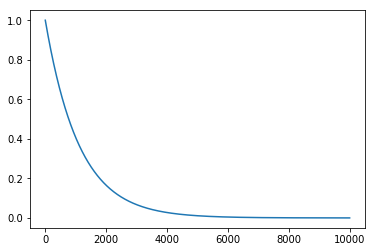

In [20]:
plt.plot(time, epsilon)
plt.show()